## QAOA for Subset_Sum Problem

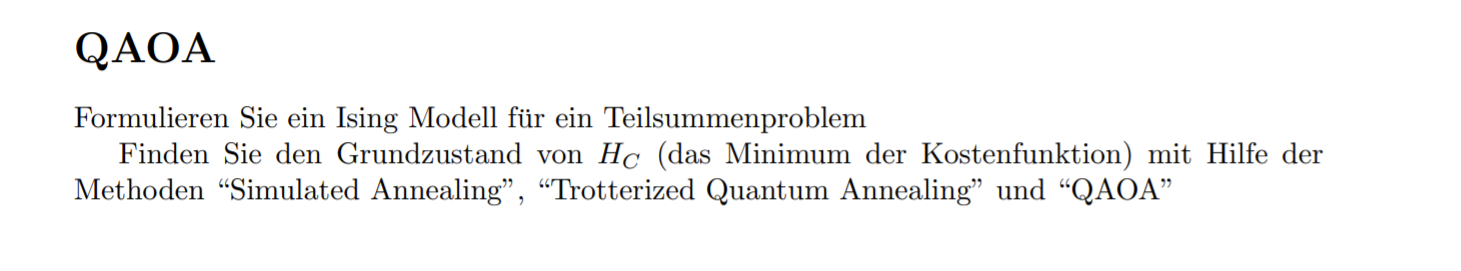

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import sys
import time
import numpy as np
import pandas as pd
import pennylane as qml
import seaborn as sns
from dwave_qbsolv import QBSolv
from matplotlib import pyplot as plt
from pennylane import qaoa
import copy
import progressbar
import os
import os.path
from qiskit import IBMQ

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import networkx as nx
import plotly.express as px
import seaborn as sns
import random

from dwave_qbsolv import QBSolv

import dimod
import neal
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.system import LeapHybridSampler

import dimod.utilities

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram

from scipy.optimize import minimize

In [3]:
#easy
number_set = [1, 2, 3]
S = 3

n_qubits = len(number_set)

In [4]:
def fill_QUBO(number_set, S):
    n = len(number_set)
    QUBO = np.zeros((n, n))
    
    #Lin Terms
    for i in range(n):
        w_i = number_set[i]
        QUBO[i][i] = w_i*w_i-2*S*w_i
        #print(w_i*w_i-2*S*w_i)
        
        #Quadratische Terms
        for j in range(i+1, n, 1):
            w_j = number_set[j]
            QUBO[i][j] = 2*w_i*w_j
    return QUBO

In [5]:
QUBO = fill_QUBO(number_set, S)
print(QUBO)

[[-5.  4.  6.]
 [ 0. -8. 12.]
 [ 0.  0. -9.]]


In [6]:
## convert QUBO to dictionary 
qubo_d = {}
x1 = 0
while x1 < n_qubits:
    x2 = x1
    while x2 < n_qubits:
        qubo_d[(x1, x2)] = int(QUBO[x1][x2])
        x2 += 1
    x1 += 1

## Lösung mit QBSolve (Simulated Annealing)

In [7]:
#QBSolve
def on_QBsolve(qubo_dictionary):
    result = QBSolv().sample_qubo(qubo_dictionary)
    return result

In [8]:
on_QBsolve(qubo_d)

SampleSet(rec.array([([1, 1, 0], -9., 24), ([0, 0, 1], -9., 27)],
          dtype=[('sample', 'i1', (3,)), ('energy', '<f8'), ('num_occurrences', '<i4')]), Variables([0, 1, 2]), {}, 'BINARY')

## Lösung mit DWave

In [9]:
#echtes HW
def on_DWave(QUBO, numr): 
    bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(QUBO)
    sampler = EmbeddingComposite(DWaveSampler())
       
    # reding num_reads responses from the sampler
    sampleset = sampler.sample(bqm, chain_strength=find_chstr(QUBO),num_reads=numr)
    return sampleset

#Find the Chain Strength following D Waves Problem Solving Handbook
def find_chstr(QUBO):
    chstr = QUBO.max() # Implementation parameter on the DWave QPU
    return chstr;

In [10]:
on_DWave(QUBO, 100)

<ipython-input-9-ebac1c19ccb7>:3: DeprecationWarning: BQM.from_numpy_matrix(M) is deprecated since dimod 0.10.0, use BQM(M, "BINARY") instead.
  bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(QUBO)


SampleSet(rec.array([([0, 0, 1], -9., 57, 0.), ([1, 1, 0], -9., 30, 0.),
           ([1, 0, 1], -8.,  1, 0.), ([0, 1, 0], -8., 12, 0.)],
          dtype=[('sample', 'i1', (3,)), ('energy', '<f8'), ('num_occurrences', '<i4'), ('chain_break_fraction', '<f8')]), Variables([0, 1, 2]), {'timing': {'qpu_sampling_time': 9204.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 51.5, 'qpu_access_time': 17652.2, 'qpu_access_overhead_time': 8405.8, 'qpu_programming_time': 8448.2, 'qpu_delay_time_per_sample': 20.54, 'total_post_processing_time': 316.0, 'post_processing_overhead_time': 316.0}, 'problem_id': '7770491d-a520-462a-b8cc-9346666ce029'}, 'BINARY')

## Lösung mit QAOA

In [11]:
qubo_d = {}
x1 = 0
while x1 < n_qubits:
    x2 = x1
    while x2 < n_qubits:
        qubo_d[(x1, x2)] = int(QUBO[x1][x2])
        x2 += 1
    x1 += 1
    
print(qubo_d)

{(0, 0): -5, (0, 1): 4, (0, 2): 6, (1, 1): -8, (1, 2): 12, (2, 2): -9}


In [12]:
isingX = dimod.qubo_to_ising(qubo_d, 0)

print(isingX)
(linear, quadratic, _) = isingX
print("\n Lineare:")
print(linear)
print("\n Quadratic:")
print(quadratic)

({0: 0.0, 1: 0.0, 2: 0.0}, {(0, 1): 1.0, (0, 2): 1.5, (1, 2): 3.0}, -5.5)

 Lineare:
{0: 0.0, 1: 0.0, 2: 0.0}

 Quadratic:
{(0, 1): 1.0, (0, 2): 1.5, (1, 2): 3.0}


In [13]:
wires = range(n_qubits)
depthX = 2

In [14]:
token = '1c854f9916477c15b8ef30c1243313b67e739cfc30f10cd741d7ad787f102bca0f0e60f474acc939c10761884cc75eff19910dbc5fb2e045c1f56dc1b274d553'
dev = qml.device("qiskit.ibmq", wires=wires, ibmqx_token=token)

In [15]:
linear_coefficents = [linear[i] for i in range(n_qubits) if i in linear]
linear_gates = [qml.PauliZ(i) for i in range(n_qubits) if i in linear]
quadratic_coefficents = [quadratic[(i, j)] for i in range(n_qubits) for j in range(n_qubits) if (i, j) in quadratic]
quadratic_gates = [qml.PauliZ(i) @ qml.PauliZ(j) for i in range(n_qubits) for j in range(n_qubits) if
                       (i, j) in quadratic]

coefficents = linear_coefficents + quadratic_coefficents
gates = linear_gates + quadratic_gates

cost_h = qml.Hamiltonian(coefficents, gates)
print(cost_h)

  (0.0) [Z0]
+ (0.0) [Z1]
+ (0.0) [Z2]
+ (1.0) [Z0 Z1]
+ (1.5) [Z0 Z2]
+ (3.0) [Z1 Z2]


In [16]:
mixer_h = qaoa.x_mixer(0)
for i in range(n_qubits - 1):
    mixer_h += qaoa.x_mixer(i + 1)
print(mixer_h)

  (1) [X0]
+ (1) [X1]
+ (1) [X2]


In [17]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [18]:
 def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depthX, params[0], params[1])

In [30]:
def qaoa(beta_gamma):
    l = len(beta_gamma)/2
    betas = beta_gamma[:l]
    gammas = beta_gamma[l:]
    
    optimizer_cost = 0
    
    for node in nodes:
        optimizer_cost += get_node_cost(gammas, betas, p, node)
    
    for edge in edges:
        optimizer_cost += get_edge_cost(gammas, betas, p, edge)
    
    optimizer_cost += L**2

    return optimizer_cost

In [29]:
#num itter
n = 1
beta_gamma = [1.0, 1.0]

In [ ]:
result = minimize(qaoa, beta_gamma, method='Cobyla')
result

In [19]:
cost_function = qml.ExpvalCost(circuit, cost_h, dev, optimize=True)

In [20]:
optimizer = qml.AdamOptimizer()

In [21]:
params = [[1.5346444645333537, 1.5932816845526026], [1.5451015974465807, 1.025692645307958]] #pre-optimized parameters

print("Start parameters: ", params)

Start parameters:  [[1.5346444645333537, 1.5932816845526026], [1.5451015974465807, 1.025692645307958]]


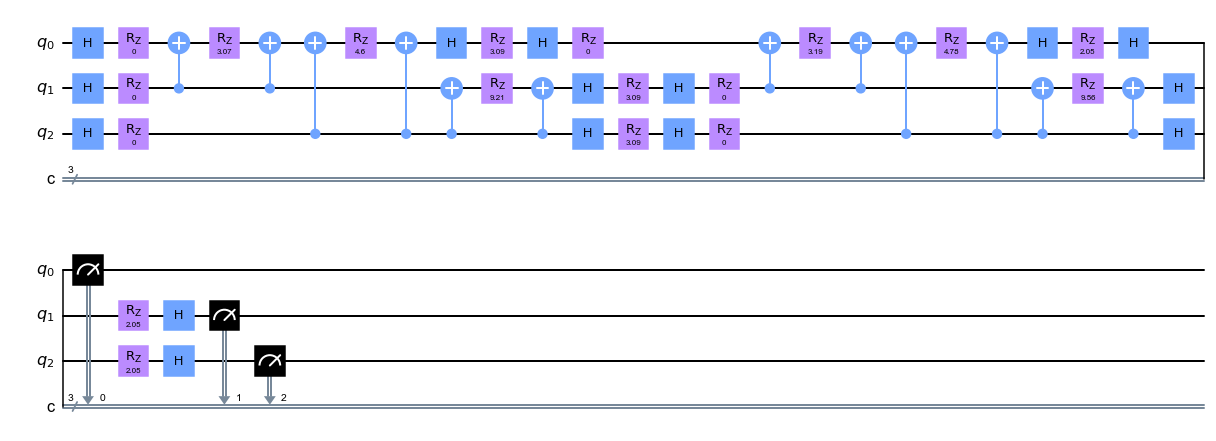

In [28]:
dev._circuit.draw(output="mpl")

In [23]:
steps = 0
optimizerType = type(optimizer).__name__
path = os.getcwd()
print(path)
savestring = path + f"\{optimizerType}_{depthX}_{steps}_{params}"
print(savestring)

C:\Users\potap\PycharmProjects\quantum-walks-away\QW\QC Praktitum Kranzlmüller\12.10
C:\Users\potap\PycharmProjects\quantum-walks-away\QW\QC Praktitum Kranzlmüller\12.10\AdamOptimizer_2_0_[[1.5346444645333537, 1.5932816845526026], [1.5451015974465807, 1.025692645307958]]


In [24]:
for i in progressbar.progressbar(range(steps), redirect_stdout=True):
    params = optimizer.step(cost_function, params)
    print(' | New parameters:', params)
    print("\n", dev.num_executions)
    f = open(savestring + "paramsQuicksaveIBM.txt", 'a+')
    f.write("parameter quicksave stepnumber " + str(i) + ": " + str(params) + "\n\n")
    f.close()

print("\n")
print("Optimal parameters: ", params)

- |#                                                  | 0 Elapsed Time: 0:00:00




Optimal parameters:  [[1.5346444645333537, 1.5932816845526026], [1.5451015974465807, 1.025692645307958]]


In [25]:
 @qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

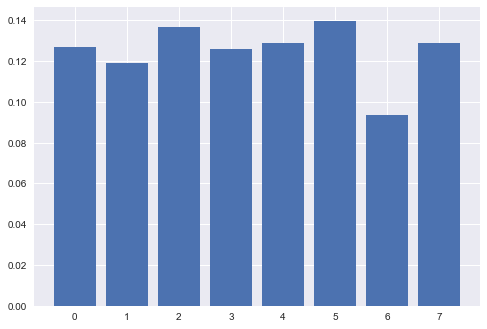

In [26]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.savefig(savestring + ".png")
plt.show()

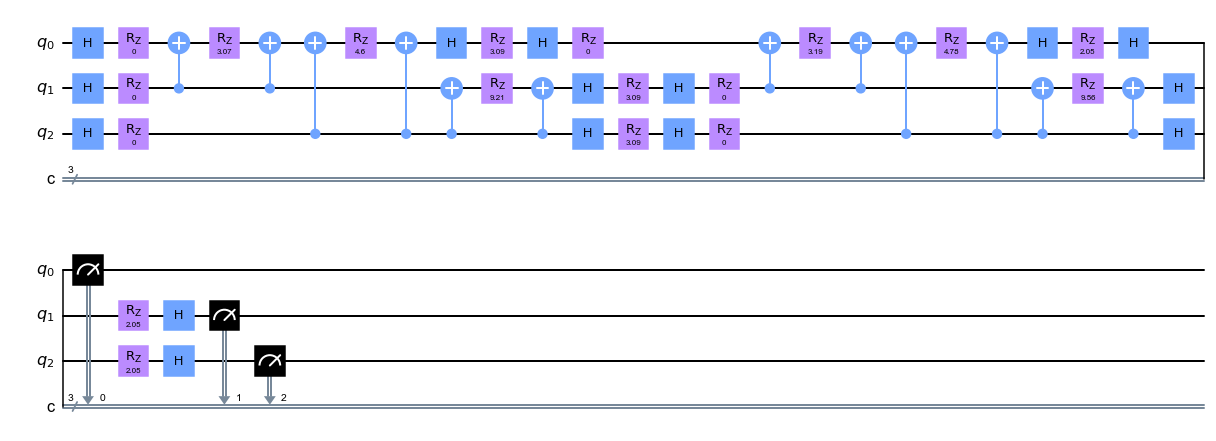

In [27]:
dev._circuit.draw(output="mpl")